# **Import librares**

In [ ]:
!pip install Keras-Preprocessing
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
from collections import Counter
from textblob import Word
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
from keras.regularizers import l2
!pip install ktrain
import ktrain
from ktrain import text
sns.set()
%matplotlib inline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('gutenberg')
nltk.download('brown')
nltk.download("reuters")
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### **Load Dataset**

In [ ]:
df=pd.read_csv("Twitter_Suicide_Dataset.csv", engine='python', encoding='UTF-8')
df=df.replace('Potential Suicide post ','Potential Suicide post')
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


# **Data Cleaning**

In [ ]:
df['Tweet']=df['Tweet'].fillna("")
df.isna().sum()

Tweet      0
Suicide    0
dtype: int64

# **Preprocessing**

In [ ]:
#Convert to lower case
df['lower_case']= df['Tweet'].apply(lambda x: x.lower())
#Tokenize
tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
#Stop words remove
stop = stopwords.words('english')
stop.remove("not")
stop.remove("here")
stop.remove("some")
df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')
#Filter words based on length
df['short_word'] = df['stop_words'].str.findall('\w{3,}')
df['string']=df['short_word'].str.join(' ')
#Removing non-english words(mention,emoji,link,special characters etc..)
words = set(nltk.corpus.words.words())
for w in reuters.words():
  words.add(w)
for w in brown.words():
  words.add(w)
for w in gutenberg.words():
  words.add(w)
df['NonEnglish'] = df['string'].apply(lambda x: " ".join(x for x in x.split() if x in words))
#Lemmatization
df['tweet'] = df['NonEnglish'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
df.head(5)

,Tweet,Suicide,lower_case,Special_word,stop_words,short_word,string,NonEnglish,tweet
0,making some lunch,Not Suicide post,making some lunch,"[making, some, lunch]","['making', 'some', 'lunch']","[making, some, lunch]",making some lunch,making some lunch,making some lunch
1,@Alexia You want his money.,Not Suicide post,@alexia you want his money.,"[alexia, you, want, his, money]","['alexia', 'want', 'money']","[alexia, want, money]",alexia want money,alexia want money,alexia want money
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post,@dizzyhrvy that crap took me forever to put to...,"[dizzyhrvy, that, crap, took, me, forever, to,...","['dizzyhrvy', 'crap', 'took', 'forever', 'put'...","[dizzyhrvy, crap, took, forever, put, together...",dizzyhrvy crap took forever put together going...,crap took forever put together going sleep days,crap took forever put together going sleep day
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post,@jnaylor #kiwitweets hey jer! since when did y...,"[jnaylor, kiwitweets, hey, jer, since, when, d...","['jnaylor', 'kiwitweets', 'hey', 'jer', 'since...","[jnaylor, kiwitweets, hey, jer, since, start, ...",jnaylor kiwitweets hey jer since start twittering,hey since start twittering,hey since start twittering
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post,trying out &quot;delicious library 2&quot; wit...,"[trying, out, quot, delicious, library, 2, quo...","['trying', 'quot', 'delicious', 'library', '2'...","[trying, quot, delicious, library, quot, mixed...",trying quot delicious library quot mixed resul...,trying quot delicious library quot mixed resul...,trying quot delicious library quot mixed resul...


## Visualization

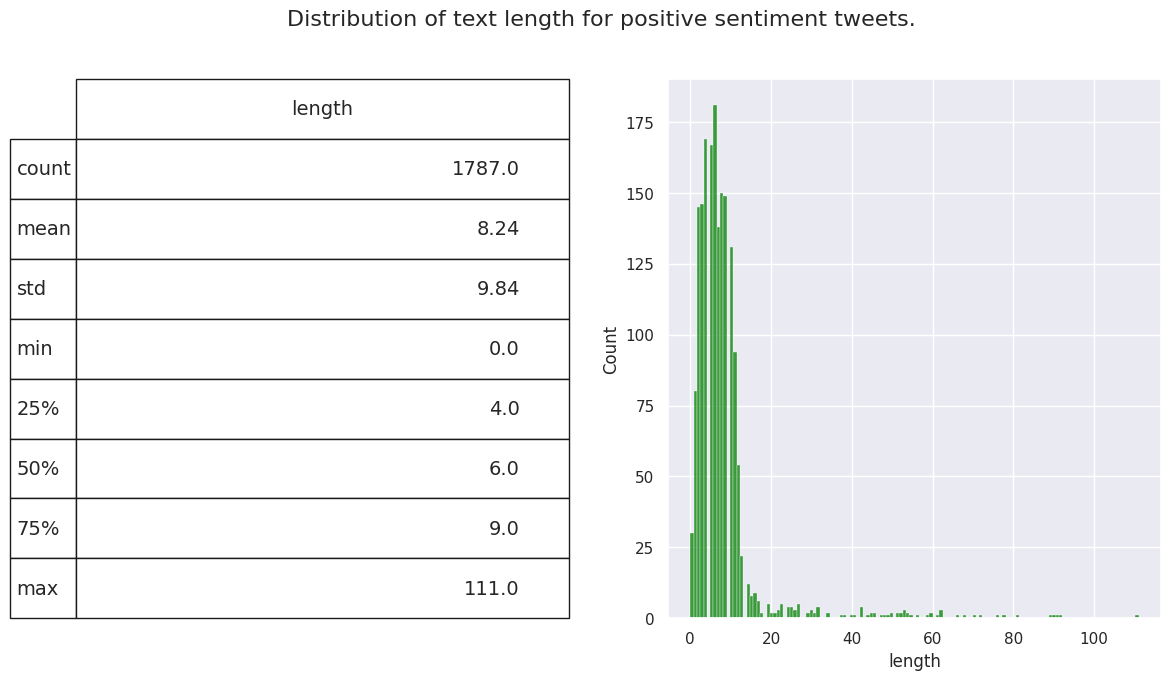

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.tweet.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

<Axes: xlabel='Suicide', ylabel='count'>

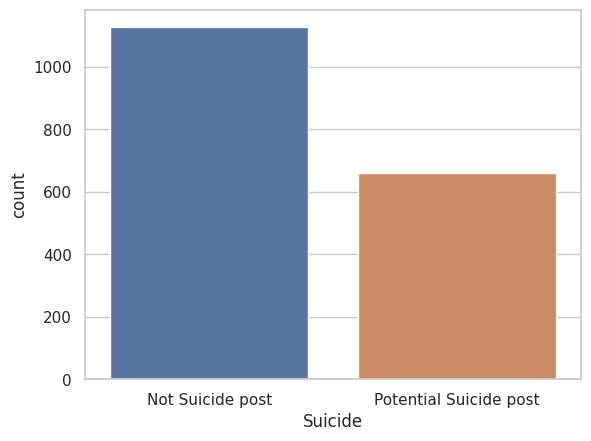

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["Suicide"])

In [ ]:
top = Counter([item for sublist in df['short_word'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
Not_Suicide_post = df[df['Suicide']=='Not Suicide post']
Potential_Suicide_post = df[df['Suicide']=='Potential Suicide post']

In [ ]:
top = Counter([item for sublist in Not_Suicide_post['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in Not_Suicide_Post', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in Potential_Suicide_post['short_word'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words in Potential_Suicide_post', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

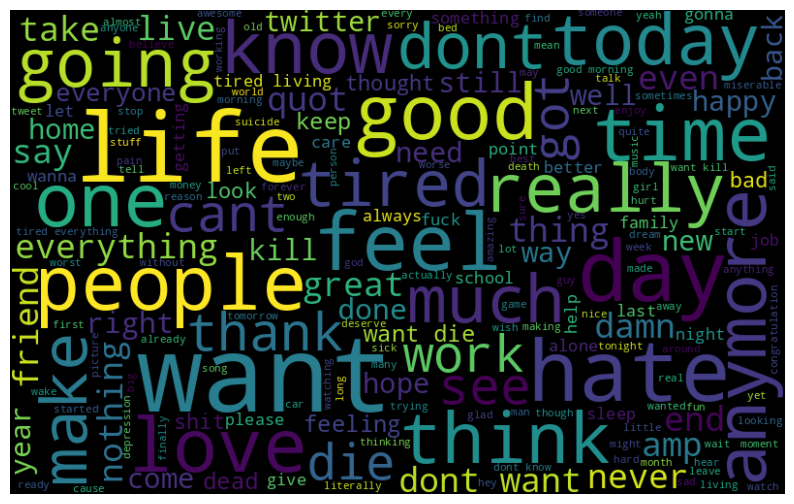

In [ ]:
normal_words =' '.join([text for text in df['tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

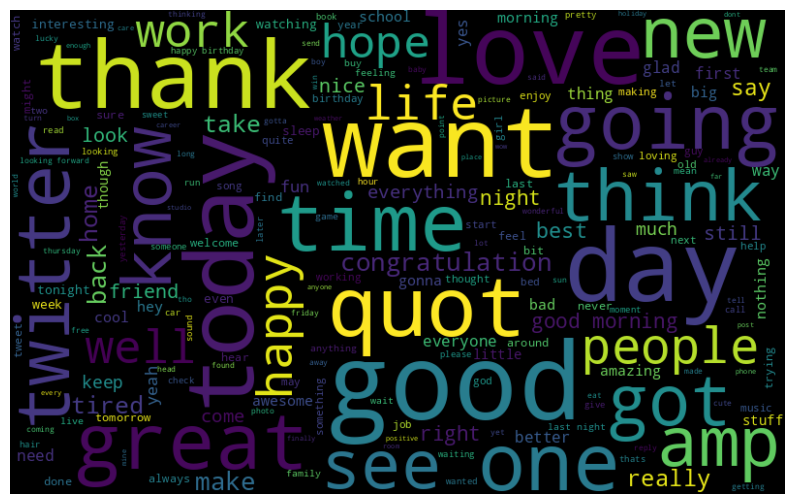

In [ ]:
normal_words =' '.join([text for text in df['tweet'][df['Suicide'] == 'Not Suicide post']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

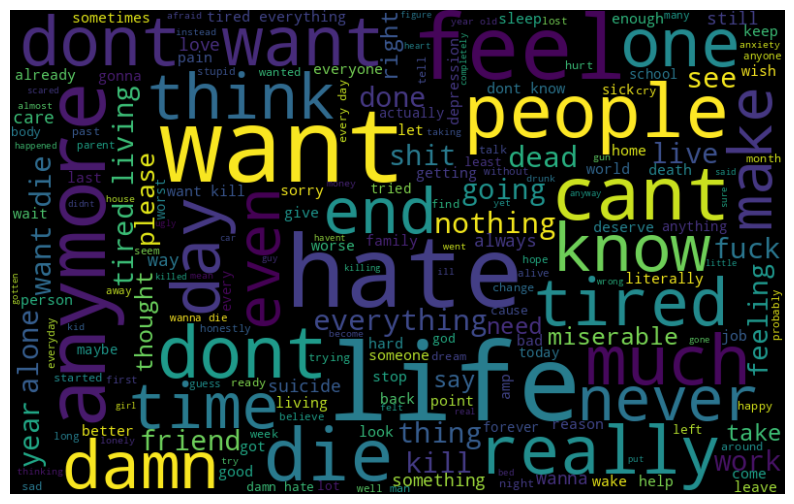

In [ ]:
normal_words =' '.join([text for text in df['tweet'][df['Suicide'] == 'Potential Suicide post']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## **Applying N-gram**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["Suicide"], test_size = 0.25, random_state = 42)
count_vect = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, y_test.shape)

(1340, 11145) (447, 11145) (1340,) (447,)


# **Deep Learning Models**

In [ ]:
vocabulary_size =6000
max_text_len = 60
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(df['Tweet'].values)
le=len(tokenizer.word_index)+1
print(le)
sequences = tokenizer.texts_to_sequences(df['Tweet'].values)
X_DeepLearning = pad_sequences(sequences, maxlen=max_text_len)
X_DeepLearning.shape[1]

6573


60

In [ ]:
# Save the tokenizer object
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
df.loc[df['Suicide'] == 'Potential Suicide post' , 'LABEL'] = 0
df.loc[df['Suicide'] == 'Not Suicide post', 'LABEL'] = 1

labels = to_categorical(df['LABEL'], num_classes=2)
print(labels[:])

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , labels, test_size=0.25, random_state=42)
print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))

((1340, 60), (1340, 2), (447, 60), (447, 2))


# **LSTM 1-Layer**

In [ ]:
epochs = 10
emb_dim = 120
batch_size = 50
model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_lstm1.add(SpatialDropout1D(0.8))
model_lstm1.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Flatten())
model_lstm1.add(Dense(64, activation='relu'))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(2, activation='softmax'))
model_lstm1.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_lstm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d (Spatial  (None, 60, 120)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 600)               1010400   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 64)                3

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-1-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_lstm1 = model_lstm1.fit(XX_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.1337 - acc: 0.9469
Epoch 1: val_acc did not improve from 0.94776
25/25 [==============================] - 14s 568ms/step - loss: 0.1337 - acc: 0.9469 - val_loss: 0.2329 - val_acc: 0.9328 - lr: 1.0000e-04
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.0838 - acc: 0.9801
Epoch 2: val_acc did not improve from 0.94776
25/25 [==============================] - 22s 906ms/step - loss: 0.0838 - acc: 0.9801 - val_loss: 0.2349 - val_acc: 0.9179 - lr: 1.0000e-04
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.0870 - acc: 0.9735
Epoch 3: val_acc did not improve from 0.94776
25/25 [==============================] - 33s 1s/step - loss: 0.0870 - acc: 0.9735 - val_loss: 0.2459 - val_acc: 0.9254 - lr: 1.0000e-04
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.0874 - acc: 0.9743
Epoch 4: val_acc did not improve from 0.94776
25/25 [==============================] - 21s 8

In [ ]:
results_1 = model_lstm1.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_1[0]} - Accuracy: {100*results_1[1]}%')

Test results - Loss: 0.1690041422843933 - Accuracy: 93.95973086357117%


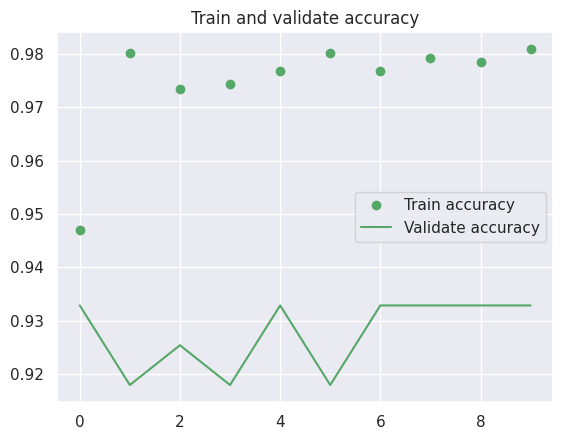

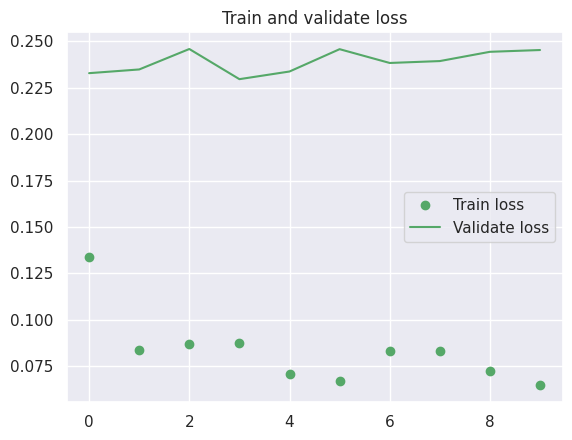

In [ ]:
acc = history_lstm1.history['acc']
val_acc = history_lstm1.history['val_acc']
loss = history_lstm1.history['loss']
val_loss = history_lstm1.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-1-layer-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/lstm 1-layer.h5')

twt = ['i will not kill myself ']
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 442ms/step
Non Suicide Post


## **LSTM 2-Layers**

In [ ]:
epochs = 10
emb_dim = 120
batch_size = 50
model_lstm2 = Sequential()
model_lstm2.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_lstm2.add(SpatialDropout1D(0.8))
model_lstm2.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences= True)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout =0.5)))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Flatten())
model_lstm2.add(Dense(64, activation='relu'))
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(2, activation='softmax'))
model_lstm2.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 60, 120)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_1 (Bidirecti  (None, 60, 400)           513600    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 60, 400)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 600)               1682400   
 onal)                                                           
                                                      

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="lastm-2-layer-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks2=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_lstm2 = model_lstm2.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=callbacks2)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.6355 - acc: 0.6468
Epoch 1: val_acc improved from -inf to 0.73134, saving model to lastm-2-layer-best_model.h5
25/25 [==============================] - 44s 1s/step - loss: 0.6355 - acc: 0.6468 - val_loss: 0.4868 - val_acc: 0.7313 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5157 - acc: 0.7803
Epoch 2: val_acc improved from 0.73134 to 0.82836, saving model to lastm-2-layer-best_model.h5
25/25 [==============================] - 30s 1s/step - loss: 0.5157 - acc: 0.7803 - val_loss: 0.3632 - val_acc: 0.8284 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.3789 - acc: 0.8474
Epoch 3: val_acc improved from 0.82836 to 0.93284, saving model to lastm-2-layer-best_model.h5
25/25 [==============================] - 29s 1s/step - loss: 0.3789 - acc: 0.8474 - val_loss: 0.2323 - val_acc: 0.9328 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA

In [ ]:
results_2 = model_lstm2.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_2[0]} - Accuracy: {100*results_2[1]}%')

Test results - Loss: 0.17121621966362 - Accuracy: 94.18344497680664%


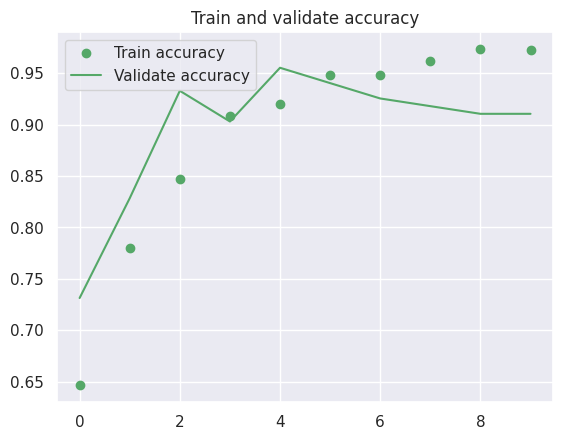

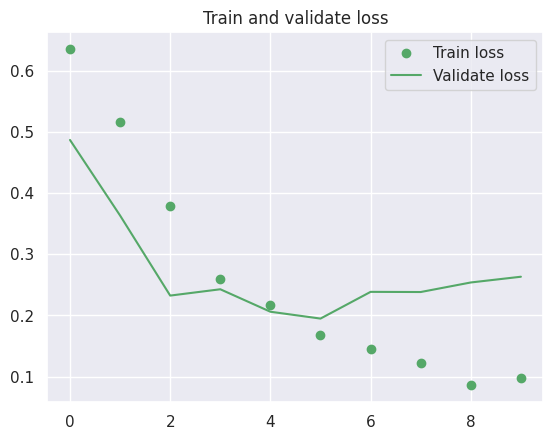

In [ ]:
acc = history_lstm2.history['acc']
val_acc = history_lstm2.history['val_acc']
loss = history_lstm2.history['loss']
val_loss = history_lstm2.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/lastm-2-layer-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/lstm 2-layer.h5')

twt = ["i will not kill myself. "]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 791ms/step
Potential Suicide Post


## **GRU**

In [ ]:
epochs = 10
emb_dim = 120
batch_size = 50
model_gru = Sequential()
model_gru.add(Embedding(vocabulary_size,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_gru.add(SpatialDropout1D(0.5))
model_gru.add(GRU(units=16,  dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(228, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(2, activation='softmax'))
model_gru.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy', metrics=['acc'])
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 60, 120)           0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 16)                6624      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 228)               3876      
                                                                 
 dropout_6 (Dropout)         (None, 228)               0         
                                                      

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="gru-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks3=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_gru = model_gru.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=callbacks3)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.4832 - acc: 0.6285
Epoch 1: val_acc improved from -inf to 0.62687, saving model to gru-best_model.h5
25/25 [==============================] - 14s 414ms/step - loss: 1.4832 - acc: 0.6285 - val_loss: 1.2947 - val_acc: 0.6269 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1655 - acc: 0.6360
Epoch 2: val_acc did not improve from 0.62687
25/25 [==============================] - 10s 395ms/step - loss: 1.1655 - acc: 0.6360 - val_loss: 1.0363 - val_acc: 0.6269 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.9381 - acc: 0.6360
Epoch 3: val_acc did not improve from 0.62687
25/25 [==============================] - 8s 303ms/step - loss: 0.9381 - acc: 0.6360 - val_loss: 0.8120 - val_acc: 0.6269 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.7110 - acc: 0.6990
Epoch 4: val_acc improved from 0.62687 to 0.90299, saving model to

In [ ]:
results_3 = model_gru.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_3[0]} - Accuracy: {100*results_3[1]}%')

Test results - Loss: 1.665008783340454 - Accuracy: 46.3087260723114%


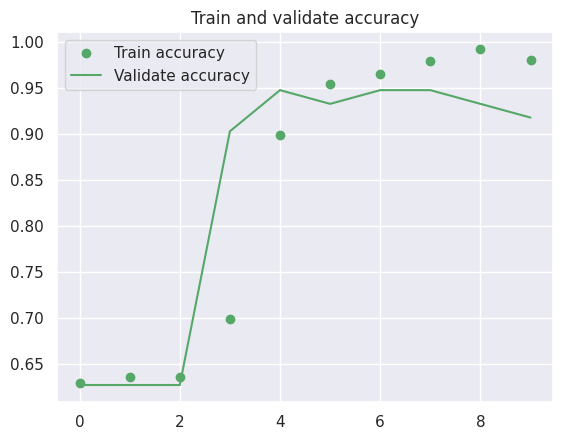

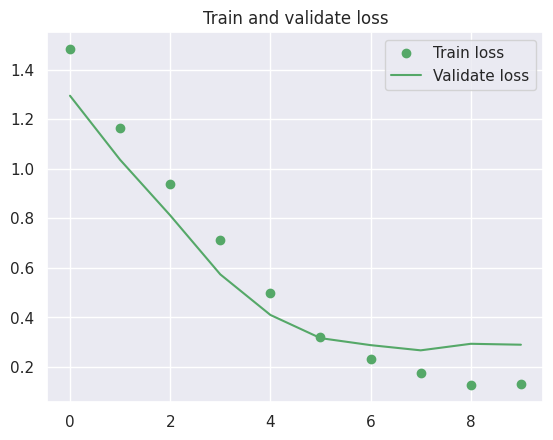

In [ ]:
acc = history_gru.history['acc']
val_acc = history_gru.history['val_acc']
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()

In [ ]:
# Load tokenizer object
with open('/content/tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/gru-best_model.h5')
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/gru-best_model.h5')

twt = ["i will not kill myself."]
twt = tokenizers.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 0s 272ms/step
Non Suicide Post


## **CNN+LSTM**

In [ ]:
epochs = 10
emb_dim = 120
batch_size = 50
model_cl = Sequential()
model_cl.add(Embedding(vocabulary_size,emb_dim, input_length=X_DeepLearning.shape[1]))
model_cl.add(SpatialDropout1D(0.8))
model_cl.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Conv1D(filters=32, kernel_size=6, activation='relu'))
model_cl.add(MaxPooling1D(pool_size=2))
model_cl.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
model_cl.add(Dropout(0.5))
model_cl.add(Bidirectional(LSTM(400, dropout=0.5, recurrent_dropout=0.5)))
model_cl.add(Dropout(0.5))
model_cl.add(Flatten())
model_cl.add(Dense(64, activation='relu'))
model_cl.add(Dropout(0.5))
model_cl.add(Dense(2, activation='softmax'))
model_cl.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
print(model_cl.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 120)           720000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 60, 120)           0         
 alDropout1D)                                                    
                                                                 
 conv1d (Conv1D)             (None, 60, 64)            46144     
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            12320     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 32)           

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath="cnn+lastm-best_model.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=1)

early_stopping_callback = EarlyStopping(monitor="val_acc", mode="max", patience=10, verbose=1, restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
history_cl = model_cl.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=callbacks)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.6504 - acc: 0.6426
Epoch 1: val_acc improved from -inf to 0.71642, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 29s 461ms/step - loss: 0.6504 - acc: 0.6426 - val_loss: 0.5764 - val_acc: 0.7164 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5493 - acc: 0.7579
Epoch 2: val_acc improved from 0.71642 to 0.85075, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 9s 352ms/step - loss: 0.5493 - acc: 0.7579 - val_loss: 0.4033 - val_acc: 0.8507 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4778 - acc: 0.8093
Epoch 3: val_acc improved from 0.85075 to 0.90299, saving model to cnn+lastm-best_model.h5
25/25 [==============================] - 8s 318ms/step - loss: 0.4778 - acc: 0.8093 - val_loss: 0.3291 - val_acc: 0.9030 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - ETA: 0s 

In [ ]:
results_4 = model_cl.evaluate(XX_test, y_test, verbose=False)
print(f'Test results - Loss: {results_4[0]} - Accuracy: {100*results_4[1]}%')

Test results - Loss: 0.2699582576751709 - Accuracy: 92.39373803138733%


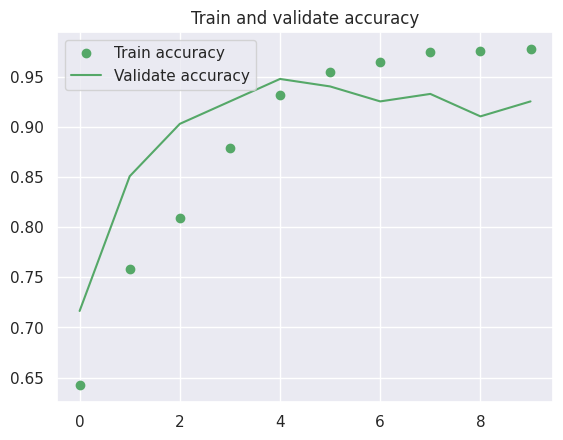

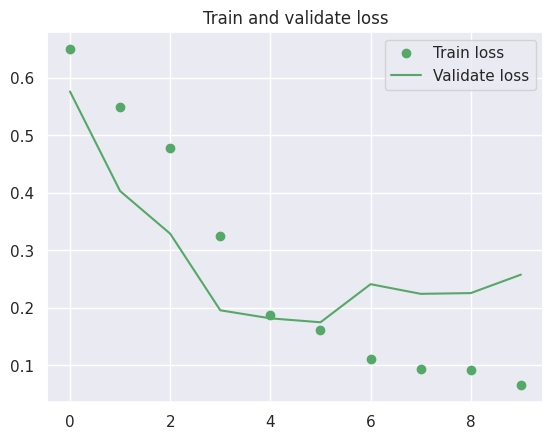

In [ ]:
acc = history_cl.history['acc']
val_acc = history_cl.history['val_acc']
loss = history_cl.history['loss']
val_loss = history_cl.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show()

In [ ]:
# Load tokenizer object
with open('tokenizer.pickle', 'rb') as handle:
    tokenizers = pickle.load(handle)

model = load_model('/content/cnn+lastm-best_model.h5')
model_cl.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/CNN+LSTM.h5')

twt = ['I will not kill myself']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=60, dtype='int32')

predicted = model.predict(twt,batch_size=1,verbose = True)
if(np.argmax(predicted) == 0):
    print("Potential Suicide Post")
elif (np.argmax(predicted) == 1):
    print("Non Suicide Post")

1/1 [==============================] - 1s 878ms/step
Non Suicide Post


## **Model Comparision**

In [ ]:
results=pd.DataFrame({'Model':['LSTM-1 Layer','LSTM-2 Layer','GRU','CNN+LSTM'],
                     'Accuracy Score':[results_1[1],results_2[1],results_3[1],results_4[1]]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score
Model,
LSTM-2 Layer,0.941834
LSTM-1 Layer,0.939597
CNN+LSTM,0.923937
GRU,0.463087


## **Bert Model**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['Suicide'], test_size=0.33, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
class_names = ['Potential Suicide post', 'Not Suicide post']

In [ ]:
(x_train,y_train), (x_val,y_val), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=140,
                                                                       max_features=5000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning:

class_names argument was ignored, as they were extracted from string labels in dataset



task: text classification


In [ ]:
model = text.text_classifier('bert', train_data=(x_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 140


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



done.


In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train,y_train),
                             val_data=(x_val,y_val),
                             batch_size=16)

In [ ]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
75/75 [==============================] - 75s 703ms/step - loss: 0.4644 - accuracy: 0.8053 - val_loss: 0.2157 - val_accuracy: 0.9373
Epoch 2/3
75/75 [==============================] - 48s 637ms/step - loss: 0.1564 - accuracy: 0.9482 - val_loss: 0.1166 - val_accuracy: 0.9627
Epoch 3/3
75/75 [==============================] - 48s 639ms/step - loss: 0.0374 - accuracy: 0.9925 - val_loss: 0.1111 - val_accuracy: 0.9610


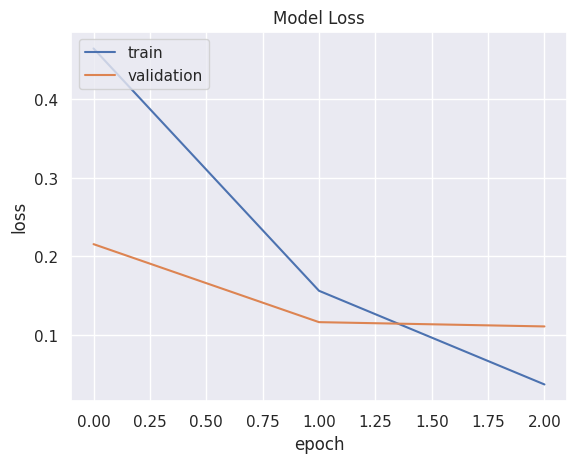

In [ ]:
learner.plot()

In [ ]:
learner.validate(val_data=(x_val,y_val), class_names=class_names)

19/19 [==============================] - 11s 316ms/step
                        precision    recall  f1-score   support

Potential Suicide post       0.96      0.98      0.97       371
      Not Suicide post       0.96      0.94      0.95       219

              accuracy                           0.96       590
             macro avg       0.96      0.96      0.96       590
          weighted avg       0.96      0.96      0.96       590



array([[362,   9],
       [ 14, 205]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['Not Suicide post', 'Potential Suicide post']

In [ ]:
message = 'i will not kill myself'
prediction = predictor.predict(message)
print('predicted: {}'.format(prediction))

predicted: Not Suicide post


**Save Bert Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
predictor.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/bert_model_Suicide")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



**Load Saved Model and Predict**

In [ ]:
predictor1 = ktrain.load_predictor('/content/drive/MyDrive/Colab_Notebooks/DL Model/Twitter Suicide Ideation Detection/bert_model_Suicide')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



In [ ]:
data = "I will end my life"
predictor1.predict(data)

'Potential Suicide post'